# Supporting Marketing Campaign Budget Planning

**Notebook Objectives** <br>
- Use the best-performing model to simulate call campaign outcomes at different calling thresholds
- Define optimal rules for targeting customers to maximize conversions per call (marketing efficiency)
- Estimate how the number of signed contracts grows with the number of calls made
- Support resource allocation by predicting the required number of calls to reach business targets (e.g., securing 300 new contracts)
- Provide strategic recommendations for budget allocation across campaigns

**Notebook Structure** <br>
1. Importing Libraries
2. Data & Model Loading
3. Cleaning & Feature Engineering
4. Signed Contract Growth & Predecting required # of calls
   

## Importing Libraries

In [1]:
import sys
import os
notebook_dir = os.path.dirname(os.getcwd())
sys.path.append(notebook_dir)
from utils import data_cleaning, feature_engineering, modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import shap
import pickle
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import warnings



# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


## Data & Model Loading

In [2]:
# Load the saved model package
try:
    with open('../Models/best_model.pkl', 'rb') as f:
        model_package = pickle.load(f)
    
    best_model_obj = model_package['model']
    scaler = model_package['scaler']
    best_threshold = model_package['threshold']
    feature_names = model_package['feature_names']
    model_info = model_package['model_info']
    
    print("Model loaded successfully:")
    print(f"  Model type: {model_info['name']} with {model_info['sampling']}")
    print(f"  F1-Score: {model_info['f1_score']:.3f}")
    print(f"  Precision: {model_info['precision']:.3f}")
    print(f"  Recall: {model_info['recall']:.3f}")
    print(f"  AUC: {model_info['auc']:.3f}")
    print(f"  Optimal threshold: {best_threshold:.3f}")
    
except FileNotFoundError:
    print("Model file 'best_model.pkl' not found!")
    print("Please run the modeling notebook first to generate the saved model.")
    exit()

Model loaded successfully:
  Model type: LightGBM with SMOTE
  F1-Score: 0.638
  Precision: 0.556
  Recall: 0.749
  AUC: 0.934
  Optimal threshold: 0.300


In [3]:
# Load
with open("../Models/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)
with open("../Models/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)
print(f"Using raw data: {X_test.shape[0]:,} calls")

Using raw data: 9,043 calls


## Cleaning & Feature Engineering

--- Dataset Overview ---
Shape: (9043, 53)
Memory Usage: 7.15 MB
Duplicate Rows: 0

--- Missing Values ---
- Age: 0 missing values
- Job: 0 missing values
- Marital: 0 missing values
- Education: 0 missing values
- Default: 0 missing values
- Balance: 0 missing values
- Housing: 0 missing values
- Loan: 0 missing values
- Contact: 0 missing values
- Day_of_week: 0 missing values
- Month: 0 missing values
- Duration: 0 missing values
- Campaign: 0 missing values
- Pdays: 0 missing values
- Previous: 0 missing values
- Poutcome: 0 missing values
- Age_group: 0 missing values
- Is_professional: 0 missing values
- Education_level: 0 missing values
- Balance_category: 0 missing values
- Balance_per_age: 0 missing values
- Has_credit_risk: 0 missing values
- Call_efficiency: 0 missing values
- Was_contacted_before: 0 missing values
- Contact_recency: 0 missing values
- Prev_campaign_success: 0 missing values
- High_contact_intensity: 0 missing values
- Month_numeric: 0 missing values
- Is_q1

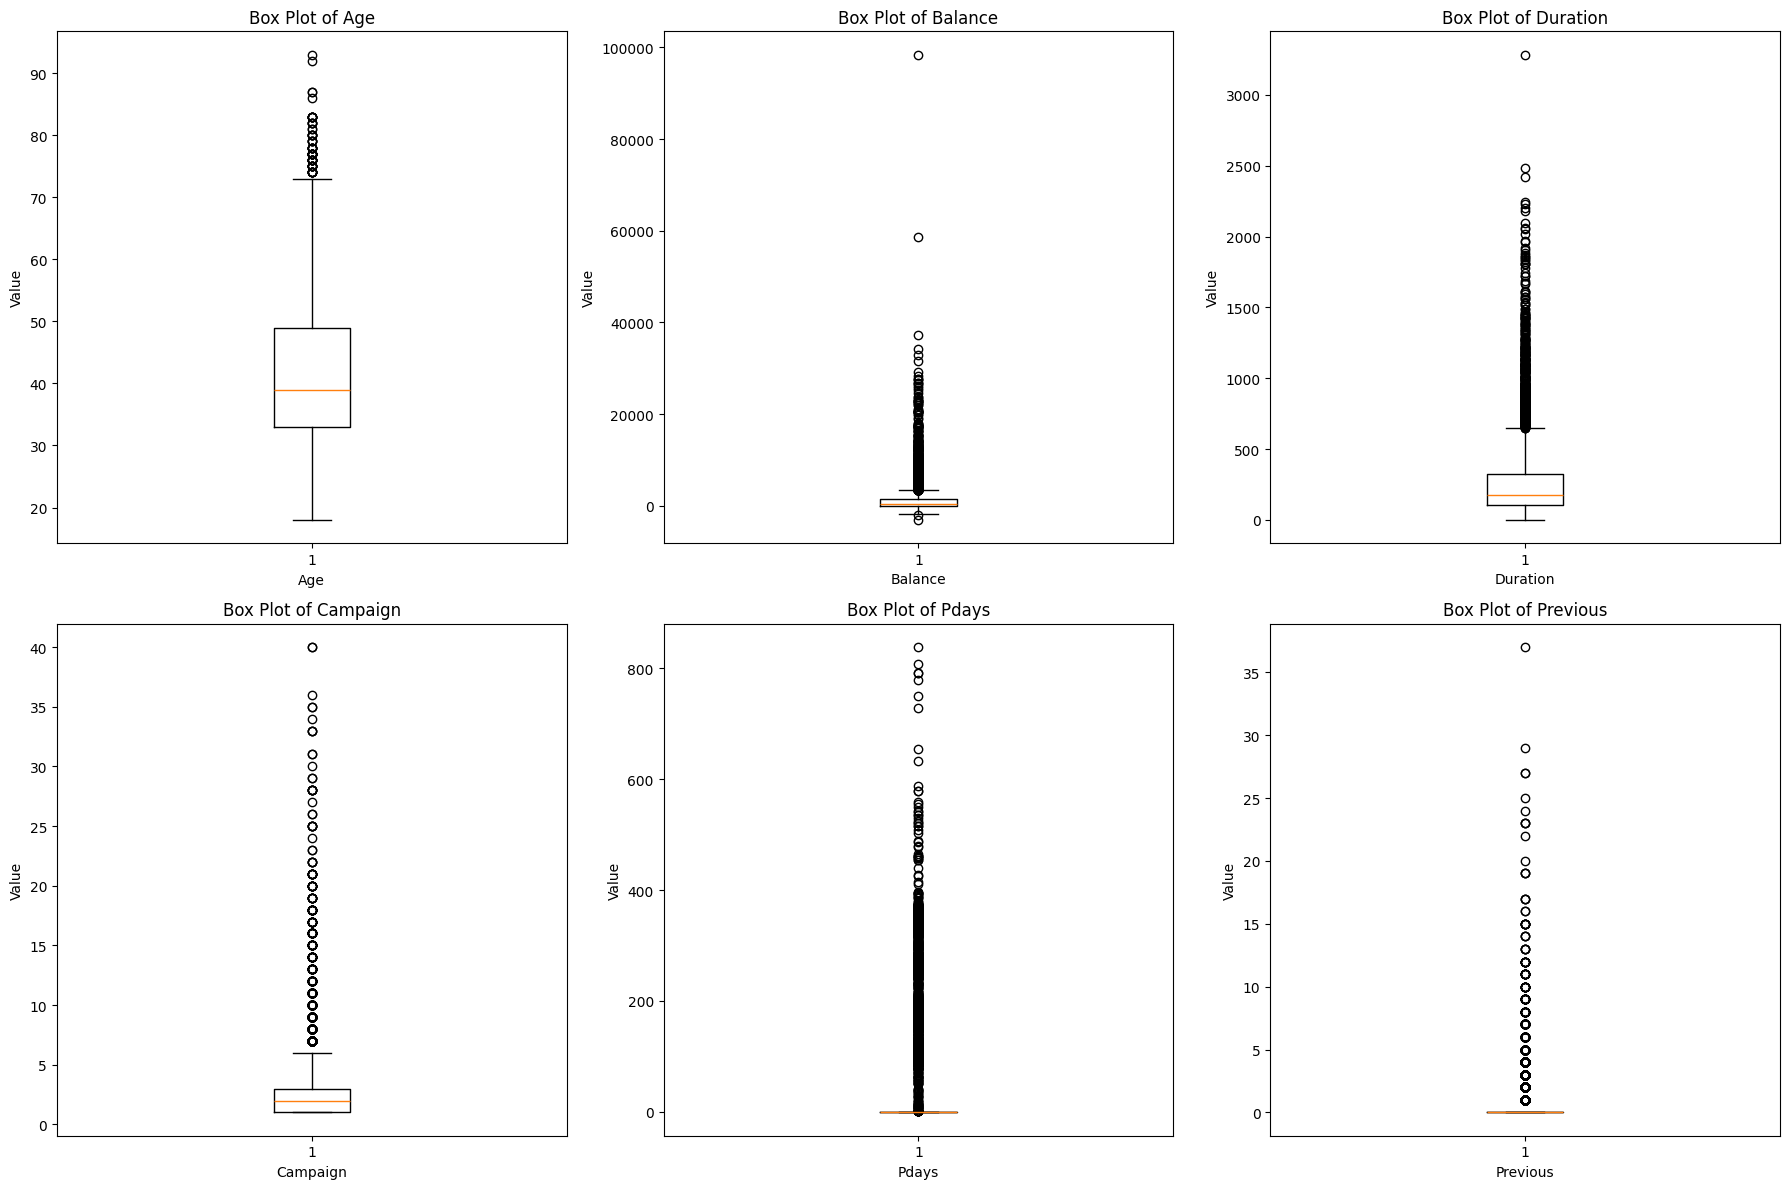

[]
final_features:['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'age_group', 'is_professional', 'education_level', 'balance_category', 'balance_per_age', 'has_credit_risk', 'call_efficiency', 'was_contacted_before', 'contact_recency', 'prev_campaign_success', 'high_contact_intensity', 'month_numeric', 'is_q1', 'is_summer', 'is_q4', 'mature_educated', 'duration_prev_success', 'customer_value_score', 'is_high_value', 'customer_stability', 'duration_percentile', 'optimal_duration', 'campaign_fatigue', 'campaign_above_median', 'contact_effectiveness', 'prev_success_rate', 'risk_appetite', 'financial_engagement', 'financial_planning_season', 'tax_season', 'vacation_season', 'balance_vs_expected', 'above_expected_wealth', 'education_job_alignment', 'quality_strategy', 'young_professional', 'established_family']
features_added: 0


In [4]:
df = X_test.copy()
clean_df          = data_cleaning.complete_data_cleaning_pipeline(df)
FE_df             = feature_engineering.create_feature_engineering_pipeline(clean_df)
# Encode & scale the features as you did in training
X_model_enc       = modeling.encode_categorical_features(FE_df, method='label')  # label because the model is lightGBM
X_model_proc,_, _   = modeling.scale_data(X_model_enc, X_model_enc, apply_scaling=True)  # scaler must be same as used in training
X_model_proc      = X_model_proc[feature_names]

## Signed Contract Growth & Predecting required # of calls

In [5]:
chosen_threshold = float(best_threshold)
pred_proba = best_model_obj.predict_proba(X_model_proc)[:
    , 1]
df_campaign = pd.DataFrame({
    "customer_id": X_model_proc.index,
    "pred_proba" : pred_proba,
    "true"       : y_test  # actual outcomes
})

# Sort by predicted probability (simulate calling most likely customers first)
df_campaign = df_campaign.sort_values("pred_proba", ascending=False).reset_index(drop=True)

# Cumulative true contracts
df_campaign["cumulative_contracts"] = np.cumsum(df_campaign["true"])


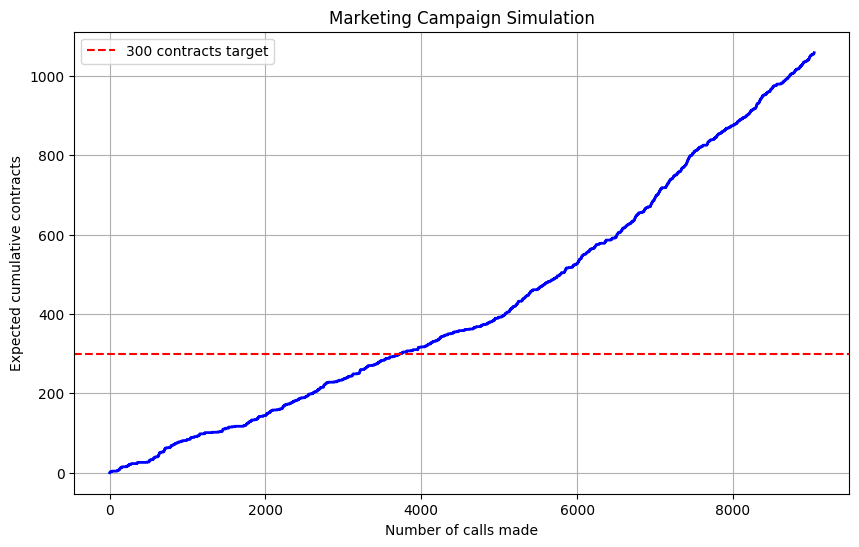

from 9,043 customers Estimated calls needed to secure 300 contracts: 3729


In [6]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(df_campaign.index+1, df_campaign['cumulative_contracts'], color='b', lw=2)
plt.axhline(300, color='r', linestyle='--', label='300 contracts target')
plt.xlabel('Number of calls made')
plt.ylabel('Expected cumulative contracts')
plt.title('Marketing Campaign Simulation')
plt.legend()
plt.grid(True)
plt.show()

calls_needed = (df_campaign['cumulative_contracts'] >= 300).idxmax() + 1
print(f"from {X_test.shape[0]:,} customers Estimated calls needed to secure 300 contracts: {calls_needed}")